# Exploratory Analysis of Ozone Data

## Import the unprocessed data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("la_aq.csv")

In [3]:
df["DateTime"] = pd.to_datetime(df["DateTime"])

In [4]:
df.head()

,DateTime,CO,NO2,O3,PM10,PM2.5,SO2,T,WD,WS
0,2000-01-01 00:00:00,2.39,26.0,1.0,59.0,NaN,NaN,53.5,356.6,0.6
1,2000-01-01 01:00:00,2.28,25.0,1.0,42.0,NaN,NaN,53.6,0.7,1.1
2,2000-01-01 02:00:00,2.44,24.0,1.0,38.0,NaN,NaN,53.8,15.4,1.0
3,2000-01-01 03:00:00,2.59,22.0,2.0,68.0,NaN,NaN,53.6,33.8,1.3
4,2000-01-01 04:00:00,0.00,0.0,0.0,80.0,NaN,NaN,53.4,30.6,1.9


In [5]:
df["O3"].describe()

count    185304.000000
mean         20.972887
std          18.495664
min           0.000000
25%           4.000000
50%          18.000000
75%          34.000000
max         153.000000
Name: O3, dtype: float64

Examine the data for yearly cyclicality:

<AxesSubplot:xlabel='DateTime'>

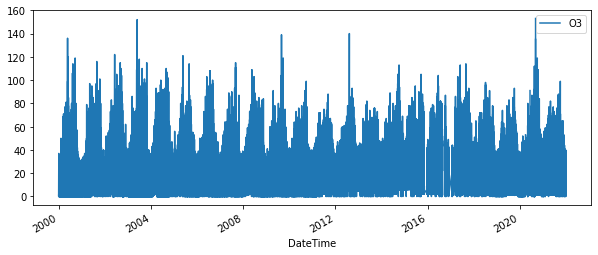

In [6]:
plt1 = df.plot(kind = "line", x = "DateTime", y = "O3", figsize = (10, 4))
plt1

And daily cyclicality:

In [7]:
from datetime import datetime

<AxesSubplot:xlabel='DateTime'>

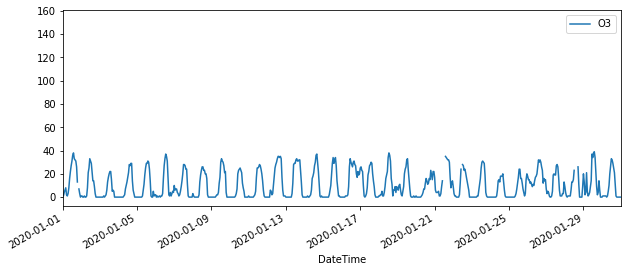

In [8]:
plt2 = df.plot(kind = "line", x = "DateTime", y = "O3", figsize = (10, 4), xlim = (datetime(2020, 1, 1), datetime(2020, 1, 31)))
plt2

It's clear that there are several layers of periodicity to this data.

## Basic data cleaning
This data set already looks pretty clean. Let's just drop any rows that do not contain O3 values.

In [9]:
df = df[["DateTime", "O3", "T", "WD", "WS"]]
df = df[df["O3"].notna()]
df

,DateTime,O3,T,WD,WS
0,2000-01-01 00:00:00,1.0,53.5,356.6,0.6
1,2000-01-01 01:00:00,1.0,53.6,0.7,1.1
2,2000-01-01 02:00:00,1.0,53.8,15.4,1.0
3,2000-01-01 03:00:00,2.0,53.6,33.8,1.3
4,2000-01-01 04:00:00,0.0,53.4,30.6,1.9
...,...,...,...,...,...
185907,2021-12-31 19:00:00,5.0,52.0,11.0,2.0
185908,2021-12-31 20:00:00,6.0,52.0,2.0,3.0
185909,2021-12-31 21:00:00,4.0,51.0,7.0,2.0
185910,2021-12-31 22:00:00,1.0,49.0,6.0,3.0


In [10]:
df["O3"].isna().sum()

0

Confirmed -- there are no rows left that do not contain a value for O3.

## Visualize the data
The distribution of NO2 data is especially of interest here.

<AxesSubplot:>

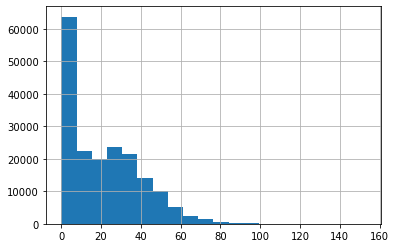

In [11]:
hist = df["O3"].hist(bins = 20)
hist

With a long tail of high O3 values, this data may ultimately benefit from a log transformation.

## Feature engineering

Introduce features to capture the date/time component:

In [12]:
df["Year"] = df["DateTime"].dt.year
df["Month"] = df["DateTime"].dt.month
df["DayOfMonth"] = df["DateTime"].dt.date
df["DayOfWeek"] = df["DateTime"].dt.dayofweek
df["DayOfYear"] = df["DateTime"].dt.dayofyear
df["Hour"] = df["DateTime"].dt.hour

Let's take a look at the correlation coefficients here, with the caveat that any of the cyclical date/time features won't be monotonic, and therefore won't give a meaningful correlation coefficient:

In [13]:
df.corr(method = "spearman")

,O3,T,WD,WS,Year,Month,DayOfWeek,DayOfYear,Hour
O3,1.000000,0.460451,0.396714,0.402112,0.151819,-0.038059,0.071424,-0.036897,0.259224
T,0.460451,1.000000,0.462866,0.346354,0.011577,0.173731,-0.006235,0.173039,0.170678
WD,0.396714,0.462866,1.000000,0.364014,-0.040989,-0.003768,0.000337,-0.002836,0.265052
WS,0.402112,0.346354,0.364014,1.000000,-0.156015,-0.049875,-0.006873,-0.049632,0.159372
Year,0.151819,0.011577,-0.040989,-0.156015,1.000000,-0.002145,0.000810,-0.002303,0.000196
Month,-0.038059,0.173731,-0.003768,-0.049875,-0.002145,1.000000,-0.000723,0.996501,-0.000460
DayOfWeek,0.071424,-0.006235,0.000337,-0.006873,0.000810,-0.000723,1.000000,-0.000685,-0.000894
DayOfYear,-0.036897,0.173039,-0.002836,-0.049632,-0.002303,0.996501,-0.000685,1.000000,-0.000457
Hour,0.259224,0.170678,0.265052,0.159372,0.000196,-0.000460,-0.000894,-0.000457,1.000000


Correlation coefficients suggest a strongly meaningful correlation between ozone levels and the three weather parameters -- temperature, wind speed, and wind direction.

Let's visualize those relationships between O3 and weather data:

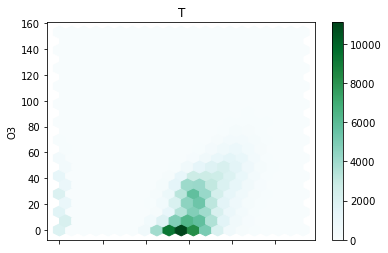

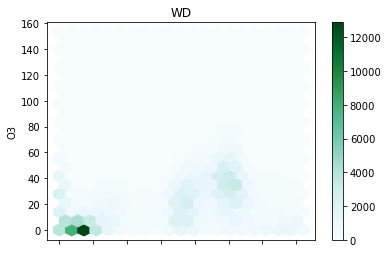

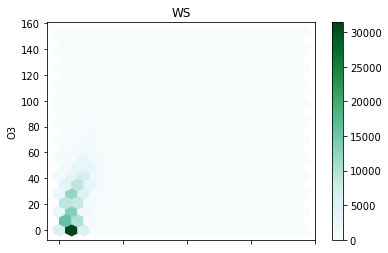

In [14]:
for param in ["T", "WD", "WS"]:
    fig = df.plot(x = param, y = "O3", kind = "hexbin", gridsize = 20, title = param)
    fig

There are _may_ be some potential correlations to temperature, wind direction and wind speed! (This also highlights some zero values for Temperature that likely need to be dropped, though.)

Let's also evaluate the *combination* of wind speed & wind direction. For example, a fast breeze from the ocean vs. a slow breeze from inland?
To answer this, let's vectorize wind speed & direction as two new features: the north-south component (with north as positive) and the east-west component (with east as positive).

In [15]:
from numpy import radians, sin, cos

In [16]:
df["WindNvec"] = cos(radians(df["WD"])) * df["WS"]
df["WindEvec"] = sin(radians(df["WD"])) * df["WS"] 

<AxesSubplot:xlabel='WindEvec', ylabel='WindNvec'>

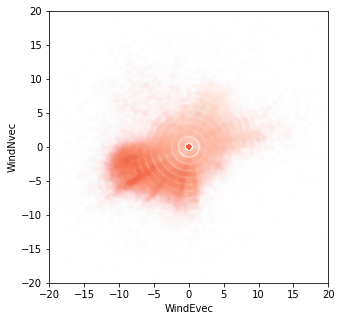

In [17]:
fig = df.plot(kind = "scatter", x = "WindEvec", y = "WindNvec", c = "O3",
              figsize = (5, 5), alpha = 0.005, colormap = "Reds", colorbar = False,
              xlim = (-20, 20), ylim = (-20, 20)) 
fig

The artifacts of collecting wind speed data as integers are pretty obvious here. Additionally, it is now very clear that strong winds blowing to the southwest favor high O3, but strong winds blowing to the northeast favor low O3.

# Finish cleaning the data
There are a lot of zero values for wind speed, wind direction, and temperature. While no wind is certainly reasonable, 0 degrees F certainly isn't plausible in Southern California. Fill these values with NaN.

In [18]:
from numpy import nan

def remove_zero_temps(row):
    if row["T"] == 0:
        row["T"] = nan
    return row

In [19]:
df = df.apply(remove_zero_temps, axis = 1)

In [20]:
df["T"].describe()

count    168902.000000
mean         64.865738
std          10.489713
min          26.700000
25%          57.400000
50%          64.000000
75%          71.300000
max         113.100000
Name: T, dtype: float64

Now erroneous temperatures of 0 degrees F have been removed.

## Save processed data

In [21]:
# List all the available potential features
df.columns

Index(['DateTime', 'O3', 'T', 'WD', 'WS', 'Year', 'Month', 'DayOfMonth',
       'DayOfWeek', 'DayOfYear', 'Hour', 'WindNvec', 'WindEvec'],
      dtype='object')

In [22]:
# Decide which ones to export
keepcols = ["DateTime", "Year", "Month", "DayOfMonth", "DayOfWeek", "DayOfYear", "Hour", "O3", "WindNvec", "WindEvec"]

In [23]:
df[keepcols].to_csv("cleaned_O3_data.csv", index = False)